# Text Information Extraction - Exercise - Linear Chain Conditional Random Fields

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge)
  * [Modules](#Python-Modules)
* [Linear Chain CRFs](#Linear-Chain-CRFs)
  * [Model of the conditional probability](#Model-of-the-conditional-probability)
  * [Feature Functions](#Feature-Functions)
  * [Simple Example](#Simple-Example)
  * [Negative energy of the system](#Negative-energy-of-the-system)
* [Exercises](#Exercises)
  * [Weight Vector $\vec{\theta}$](#ex-weight-vector-theta)
  * [Setup for programming exercises](#Setup-for-programming-exercises) (not a task)
  * [Total negative energy](#Exercise%3A-Total-negative-energy)
  * [Probabilities for the Spin System](#Exercise%3A-Probabilities-for-the-Spin-System)
  * [Conditional Probability](#Exercise%3A-Conditional-Probability) 
  * [Data](#Exercise%3A-Data)
  * [Dynamic Programming for the Partition Function](#Exercise%3A-Dynamic-Programming-for-the-partition-function)
  * [Brute Force Comparison](#Exercise%3A-Brute-force-comparison)
  * [Alpha values](#Exercise%3A-Alpha-values)
  * [Beta values](#Exercise%3A-Beta-values)
* [Summary and Outlook](#Summary-and-outlook)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

This notebook aims to provide a gentle introduction to Linear Chain Conditional Random Fields.

First, we'll introduce an example that uses two hidden states and short sequences of length 3. This allows us to
* model a CRF with a managable size
* find features and assign weights by hand
* calculate probabilities through brute force

Then, you'll implement more efficient algorithms that can handle longer sequences. Your findings from the initial approach can help you debug those algorithms.

At the end of the notebook you'll have a good grasp of the CRF model. We won't be dealing with training/classifiying CRFs but you'll have implemented a collection of algorithms to prepare you for the task.

## Requirements

### Knowledge
Linear Chain CRFs are an advanced method of sequence classification. If you're new to the topic, starting with the more common approaches of Hidden Markov Models (HMM / MEMM) is recommended.

CRF:
* The original paper \[[LAF01](#LAF01)\]
* Videos and slies from \[[LAR13](#LAR13)\]

### Python Modules

In [ ]:
import numpy as np
import pandas as pd
import scipy.misc
from IPython.display import display

def print_weights(w):
    for i,prev_state in enumerate(crf_data.states):
        weights = pd.DataFrame(
            index=crf_data.states,
            columns=crf_data.features,
            data=w[i,:,:]
        )
        weights.name = 'previous state: {}'.format(prev_state)
        display(weights)

np.random.seed(seed=99)

## Linear Chain CRFs

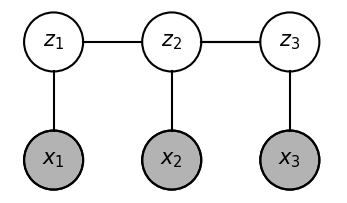

### Model of the conditional probability
We're interested in the conditional probability of the entire sequence of labels $z$ given the input sequence $x$. In this notation there are $T$ positions (or time points) in the sequence.

$$
p(z_{1:T} \mid x_{1:T}, \vec \theta) = \frac{1}{Z}\prod_{t=1}^T F(z_{t-1}, z_t, x_{1:T}, t)
$$

$F(z_{t-1}, z_t, x_{1:T}, t)$ are the (unnormed) Factors with
* weight vector $\vec{\theta}$
* feature vector $\vec{f}$, which we get by applying a feature function to the input.
$$
= \frac{1}{Z}\prod_{t=1}^T \exp\left (\vec \theta \cdot \vec f(z_{t-1}, z_t, x_{1:T}, t)\right)
$$

For normalisation we divide by the partition function $Z$ (Zustandssumme), which is the sum of unnormed factors over all possible sequences $\vec z'$
$$
Z = \sum_{\vec z'}\prod_{t=1}^T  \exp\left (\vec \theta \cdot \vec f(z'_{t-1}, z'_t, x_{1:T}, t)\right)
$$

### Feature Functions

$$
f_j(z_{t-1}, z_t, x_{1:T}, t)
$$

The (indicator) features can depend on the previous hidden state, the current hidden state, all the observations and the time index. 

We introduce a simple example for two purposes:
- for didactic reasons
- to have a simple example we can solve by enumeration. So we can test and debug our algorithms much better.

### Simple Example

Let's assume we have a small spin system of 6 spins:

- Three hidden spins $s_t$ and three observed spins $x_t$ with $t \in\{1,2,3\}$).  

- The possible spin states are: $val(s_t)$ = $val(x_t)$ = {UP, DOWN}.
- The first (hidden) spin $s_1$ sees a small magnetic field, so the energy between UP and DOWN is slightly different:
$E(s_1=\text{UP})<E(s_1=\text{DOWN})$.
- The hidden spins $s_1, s_2, s_3$ are coupled such that adjacent spins with equal state values have lower contibution to the energy, e.g. $E(s_1=\text{UP}, s_2=\text{UP})<E(s_1=\text{UP}, s_2=\text{DOWN})$.
- We observe 3 spins ${x_1, x_2, x_3}$. Each observed spin is coupled with exactly one hidden spin. 
e.g. $E(s_t=\text{UP}, x_t=\text{UP})<E(s_t=\text{UP}, x_t=\text{DOWN})$.

i.e. the coupling coeffients (see below) $c_1, c_{sx}, c_{ss}$ are all positive.

### CRF

Graphical representation of a linear chain CRF with two possible types of factors $F(z_{t-1}, z_t, t)$ and $F(z_t, x_t)$ and $t \in {1,2,3}$.

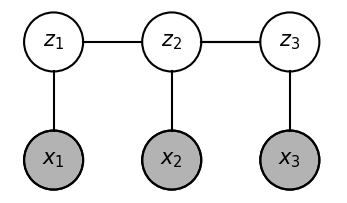

The probability of the state of the system depends on its total energy $E$ and is given by the Boltzman Factor:
$$
P(E) = \exp \left( - \frac{E}{kT}\right)
$$

We set $kT$ equals 1 for simplicity:

$$
P(E) =  \exp \left( - E \right)
$$

The higher the energy, the (exponentially) lower is the probability of a state. 

### Negative energy of the system

with 
- DOWN $s_i=-1$ and 
- UP $s_i= +1$ 


$$
- E(s_{1:T}, x_{1:T}) = c_1  s_1+ c_{sx} \sum_{t=1}^3 s_t x_t  + c_{ss} \sum_{t=2}^3 s_{t-1} s_t
$$

with
- $s_{1:T} = (s_1, s_2, s_3)$ (hidden spins)
- $x_{1:T} = (x_1, x_2, x_3)$ (observed spins)

here $T=3$.

The total energy of the system is a sum of local contributions.

$$
\begin{align}
p(s_{1:T}, x_{1:T})
& = \frac{1}{Z} \exp\left(-E(s_{1:T}, x_{1:T})\right) \\
& = \frac{1}{Z} \exp\left( c_1  s_1+ c_{sx} \sum_{t=1}^3 s_t x_t  + c_{ss} \sum_{t=2}^3 s_{t-1} s_t\right)
\end{align}
$$

with the partition function $Z$ (Zustandsumme) for the normalization:
$$
Z = \sum_{s'_{1:T}, x'_{1:T}}  \exp \left(-E(s'_{1:T}, x'_{1:T}) \right)
$$

We get the conditional probability just by using another $Z$:
$$
\begin{align}
p(s_{1:T} \mid  x_{1:T})
& = \frac{1}{Z(x_{1:T})} \exp\left(-E(s_{1:T}, x_{1:T})\right) \\
& = \frac{1}{Z(x_{1:T})} \exp\left(  c_1  s_1+ c_{sx}\sum_{t=1}^3 s_t x_t  + c_{ss} \sum_{t=2}^3 s_{t-1} s_t\right)
\end{align}
$$

Here the partition function $Z$ is given by the sum over all possible hidden states $s'_{1:T}$:

$$
Z(x_{1:T})= \sum_{s'_{1:T}}  \exp \left(-E(s'_{1:T}, x_{1:T}) \right)
$$

## Exercises

## Feature function templates

As for HMMs we introduce a special start state $\text{BOS}$ (begin of sequence) 
for a probability factor which depends only on the first state ($t=1$).

We write $z_t$ for the random variable of the hidden states with $z_t \in \{\text{BOS, DOWN, UP}\}$ 

So: $z_0 = \text{BOS}$

We introduce general feature function templates of the following form $f_k(z_{t-1}, z_t, \vec x, t)$.
Here we use only indicator functions ($\mathbb 1$) as features (as for MEMMs). There are three different templates of features :
- Bias-Feature Template:   
$f_j(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = v_n \land z_t=v_m$)
- Observation=DOWN Template:   
  $f_k(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = v_n\land z_t=v_m)$
- Observation=UP Template:     
$f_l(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = v_n\land z_t=v_m)$


Here each feature template has $3 \cdot 3 \cdot 3$  different features (3 possible hidden states). In total we have $3\cdot3\cdot3$ features.

Note: The hidden states $z_{t-1}$ and $z_t$ are arguments of the feature functions.
With the possible values for the hidden states: $v_n\in \{ \text{BOS, DOWN, UP}\}$

Note that some of the features are never used. But to keep the notation clear and to generate the features (from the 
feature templates) automatically we use this structure.
In a more efficient implementation we would eliminate never used features.

## Exercises

<a name='ex-weight-vector-theta'></a>
### Exercise: Weight vector $\vec \theta$



---

We can express each local feature using our feature function templates. Assume a sequence starts with the DOWN state. This sequence exhibits a bias-feature from START to DOWN, expressed by the feature function

- $f_0(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = START\land z_t=DOWN)$

The weight we assign to this feature is $c_1 * s_i=DOWN$ with the coupling  coefficient $c_1$ and the energy contribution from the down state $-1$.

- $\theta_0$ = -$c_1$

--- 

Another example: A transition from $z_{t-1} = DOWN$ to $z_t = UP$ can be expressed with the bias-feature
- $f_{7}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = DOWN\land z_t=UP)$

The weight we assign to this feature is
$$
\begin{align}
    c_{ss} &* s_i = DOWN * s_i = UP \\
  = c_{ss}   & * -1 * 1
\end{align}
$$
i.e. the coupling coefficient $c_{ss}$, multiplied by the energy contribution from the DOWN state and the energy contribution from the UP state. So

- $\theta_1$ = -$c_{ss}$

---

With the general template feature function $f_k(z_{t-1}, z_t, \vec x, t)$, we could construct $3 \cdot 3 \cdot 3 = 27$ feature functions in total. (Three possible states for each of the previous state, current state and current observation).

---


What is the purpose of this notation? In the previous exercise we mentioned the total negative energy is a sum of its local contributions, using the formula
$$
\begin{align}
p(s_{1:T} \mid x_{1:T}) & = 
  \frac{1}{Z(x_{1:T})} \exp\left(-E(s_{1:T} , x_{1:T})\right) \\
  & =
   \frac{1}{Z(x_{1:T})} \exp\left(  c_1  s_1 + c_{sx} \sum_{t=1}^3 s_t x_t  + c_{ss}  \sum_{t=2}^3 s_{t-1} s_t\right)
\end{align}
$$


We now generalize this calculation for a CRF model, where we extract each feature present in the sequence. We can then calculate the negative energy as the sum of all weighted features exhibited by the sequence.

$$
\begin{align}
p(z_{1:T} \mid x_{1:T}, \vec \theta) & = 
  \frac{1}{Z(x_{1:T})}\prod_{t=1}^T \exp\left (\vec \theta \cdot \vec f(z_{t-1}, z_t, x_{1:T}, t)\right)\\
  & = \frac{1}{Z(x_{1:T})} \exp\left( \sum_{t=1}^T (\vec \theta \cdot \vec f(z_{t-1}, z_t, x_{1:T}, t))\right)
\end{align}
$$



---

**Task**: Assign appropriate weights to the feature functions listed below. We mentioned there are 27 possible feature functions, but some features are never used. For example, a transition from START to START cannot occur. These impossible features should be assigned a weight of 0, but here we omitted them altogether.

Bias-Features:
- $f_0(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = START \land z_t= DOWN)$
- $f_1(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = START \land z_t= UP)$
- $f_2(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = DOWN \land z_t= DOWN)$
- $f_3(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = DOWN \land z_t= UP)$
- $f_4(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = UP \land z_t= DOWN)$
- $f_5(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = UP \land z_t= UP)$

Observation-Features:
- $f_6(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t} = DOWN \land x_t= DOWN)$
- $f_7(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t} = DOWN \land x_t= UP)$
- $f_8(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t} = UP \land x_t= DOWN)$
- $f_9(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t} = UP \land x_t= UP)$

Corresponding weights:
 - $\theta_0 = $
 - $\theta_1 = $
 - $\theta_2 = $
 - $\theta_3 = $
 - $\theta_4 = $
 - $\theta_5 = $
 - $\theta_6 = $
 - $\theta_7 = $
 - $\theta_8 = $
 - $\theta_9 = $

_Start-Features_:    
 - $f_0(z_{t-1}, z_t, \vec x, t) = \mathbb 1(t=1 \land z_{t-1} = START \land z_t= START)$
 - $f_1(z_{t-1}, z_t, \vec x, t) = \mathbb 1(t=1 \land z_{t-1} = START\land z_t=DOWN)$
 - $f_2(z_{t-1}, z_t, \vec x, t) = \mathbb 1(t=1 \land z_{t-1} = START \land z_t=UP)$
 - $f_3(z_{t-1}, z_t, \vec x, t) = \mathbb 1(t=1 \land z_{t-1} = DOWN \land z_t= START)$
 - $f_4(z_{t-1}, z_t, \vec x, t) = \mathbb 1(t=1 \land z_{t-1} = DOWN\land z_t=DOWN)$
 - $f_5(z_{t-1}, z_t, \vec x, t) = \mathbb 1(t=1 \land z_{t-1} = DOWN \land z_t=UP)$
 - $f_6(z_{t-1}, z_t, \vec x, t) = \mathbb 1(t=1 \land z_{t-1} = UP \land z_t= START)$
 - $f_7(z_{t-1}, z_t, \vec x, t) = \mathbb 1(t=1 \land z_{t-1} = UP\land z_t=DOWN)$
 - $f_8(z_{t-1}, z_t, \vec x, t) = \mathbb 1(t=1 \land z_{t-1} = UP \land z_t=UP)$

Corresponding weights:
 - $\theta_0 = $
 - $\theta_1 = $
 - $\theta_2 = $
 - $\theta_3 = $
 - $\theta_4 = $
 - $\theta_5 = $
 - $\theta_6 = $
 - $\theta_7 = $
 - $\theta_8 = $

_Bias-Features_:   
 - $f_9(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = START \land z_t=START)$
 - $f_{10}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = START \land z_t=DOWN)$
 - $f_{11}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = START \land z_t=UP)$
 - $f_{12}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = DOWN \land z_t=START)$
 - $f_{13}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = DOWN \land z_t=DOWN)$
 - $f_{14}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = DOWN \land z_t=UP)$
 - $f_{15}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = UP \land z_t=START)$
 - $f_{16}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = UP \land z_t=DOWN)$
 - $f_{17}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(z_{t-1} = UP \land z_t=UP)$

Corresponding weights:
 - $\theta_9 = $
 - $\theta_{10} = $
 - $\theta_{11} = $
 - $\theta_{12} = $
 - $\theta_{13} = $
 - $\theta_{14} = $
 - $\theta_{15} = $
 - $\theta_{16} = $
 - $\theta_{17} = $

_Observation=DOWN Features_:   
 - $f_{18}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = START\land z_t=START)$
 - $f_{19}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = START\land z_t=DOWN)$
 - $f_{20}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = START\land z_t=UP)$
 - $f_{21}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = DOWN\land z_t=START)$
 - $f_{22}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = DOWN\land z_t=DOWN)$
 - $f_{23}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = DOWN\land z_t=UP)$
 - $f_{24}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = UP\land z_t=START)$
 - $f_{25}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = UP\land z_t=DOWN)$
 - $f_{26}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{DOWN} \land z_{t-1} = UP\land z_t=UP)$

Corresponding weights:
 - $\theta_{18} =$
 - $\theta_{19} =$
 - $\theta_{20} =$
 - $\theta_{21} =$
 - $\theta_{22} =$
 - $\theta_{23} =$
 - $\theta_{24} =$
 - $\theta_{25} =$
 - $\theta_{26} =$

_Observation=UP Features_:   
 - $f_{27}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = START\land z_t=START)$
 - $f_{28}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = START\land z_t=DOWN)$
 - $f_{29}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = START\land z_t=UP)$
 - $f_{30}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = DOWN\land z_t=START)$
 - $f_{31}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = DOWN\land z_t=DOWN)$
 - $f_{32}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = DOWN\land z_t=UP)$
 - $f_{33}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = UP\land z_t=START)$
 - $f_{34}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = UP\land z_t=DOWN)$
 - $f_{35}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = UP\land z_t=UP)$

Corresponding weights:
 - $\theta_{28} =$
 - $\theta_{28} =$
 - $\theta_{29} =$
 - $\theta_{30} =$
 - $\theta_{31} =$
 - $\theta_{32} =$
 - $\theta_{33} =$
 - $\theta_{34} =$
 - $\theta_{35} =$

### Setup for programming exercises

This snippet defines a few useful constants regarding each state and their respective energy contributions.

In [ ]:
# Names for each state
UP = "UP"
DOWN = "DOWN"
START = "<BOS>"

# Energy contribution from the state
E_UP = 1.
E_DOWN = -1.
E_START = 1.5

# Map name of the state to its energy contribution
STATE_DICT = {
    START: E_START,
    DOWN: E_DOWN,
    UP: E_UP
}

# States without START
INNER_STATES = [UP, DOWN]

# Length of the example sequence
LENGTH = 3

# Values of the coupling constants
smn = 5 # influence of the first spin energy due to outer magnetic field 
c_1 = 1/smn

c_ss = .5
c_sx = .75

### Exercise: Total negative energy

Implement a python function to calculate the total negative energy for a spin system. In [Negative energy of the system](#Negative-energy-of-the-system) we defined this value as the sum of its local contributions
$$
- E(s_{1:T}, x_{1:T}) = c_1  s_1+ c_{sx} \sum_{t=1}^3 s_t x_t  + c_{ss} \sum_{t=2}^3 s_{t-1} s_t
$$

In [ ]:
def negative_sequence_energy(s,x):
    # s : hidden spins
    # x : observed spins
    # returns : the total negative energy of the sequence -E(s,x)
    raise NotImplementedError()

Verify your result:

In [ ]:
s = [UP,UP,UP]
x = [UP,UP,UP]
np.testing.assert_almost_equal(negative_sequence_energy(s,x), 3.45)

In [ ]:
s = [DOWN,DOWN,UP]
x = [UP,UP,DOWN]
np.testing.assert_almost_equal(negative_sequence_energy(s,x), -2.45)

### Exercise: Probabilities for the Spin System

Implement a python function to compute the probability by (brute force) enumeration of the Spin-System for $p(s_{1:T}, x_{1:T})$.

**Hint:**


That means, calculate 
$$
p(s_{1:T} , x_{1:T}) = \frac{1}{Z(x_{1:T})} \exp\left(-E(s_{1:T}, x_{1:T})\right)
$$

by calculating $Z$ for every possible combination of $s'_{1:T}$ and $x'_{1:T}$:

$$
Z = \sum_{s'_{1:T}, x'_{1:T}}  \exp \left(-E(s'_{1:T}, x'_{1:T}) \right)
$$

In [ ]:
def prob(s,x):
    # Returns the probability of the hidden spins s and observed spins x.
    # Don't confuse this with the conditional probability p(s|x)!
    raise NotImplementedError()

Verify your result:

In [ ]:
s = [UP,UP,UP]
x = [UP,UP,UP]
np.testing.assert_almost_equal(prob(s, x), 0.1748584549)

In [ ]:
s = [DOWN,DOWN,DOWN]
x = [DOWN,DOWN,DOWN]
np.testing.assert_almost_equal(prob(s, x), 0.117211127549)

In [ ]:
s = [DOWN,UP,DOWN]
x = [UP,DOWN,UP]
np.testing.assert_almost_equal(prob(s, x), 0.0001762198)

### Exercise: Conditional Probability

Implement a function `cond_prob(s, x)` which computes the probability of a given hidden sequence 
conditioned on a observed sequence, i.e. $p(s_{1:T} \mid x_{1:T})$

How many terms must we add to compute $Z(x_{1:T})$ (for $p(s_{1:T} \mid x_{1:T})$)?
- For our Spin System
- In general (with the number of possible hidden states $|\mathcal S|$) (without the start state)

In [ ]:
def cond_prob(s,x):
    # s : sequence of hidden spins
    # x : sequence of observed spins
    # returns p(s|x) the conditional probability of hidden spins given observed spins
    raise NotImplementedError()

Verify your result:

In [ ]:
s = [UP,UP,DOWN]
x = [UP,UP,DOWN]
np.testing.assert_approx_equal(cond_prob(s, x), 0.49151220231149634)

In [ ]:
s = [UP,UP,UP]
x = [UP,UP,UP]
cp = cond_prob(s, x)
np.testing.assert_approx_equal(cp, 0.826540721870722)

### Exercise: Data

Note: It's not possible to sample from a CRF which models $p(z_{1:T}\mid  x_{1:T})$. 
It's a discriminative model and not a generative model.

But here we can sample because we have also model of $p(z_{1:T}, x_{1:T})$

The sequences should be in the format used by CRF Suite. Have a look at [their tutorial](#https://github.com/scrapinghub/python-crfsuite/blob/master/examples/CoNLL%202002.ipynb) or the docstring in the code skeleton below.

We'll be using sequences of a fixed length $T$. So far we've dealt with sequences with  $T = 3$ but feel free to choose a different value now.

1. Sample data by "naive brute force" sampling, i.e.:
 * Enumerate all possible sequences $z_{1:T} \in \{UP, DOWN\}$ and $x_{1:T} \in \{UP, DOWN\}$.
 * Compute the probability of each sequence using your implementation `prob(s,x)`
 * Then you can sample by `np.random.choice(a=possible_seq,size=size,p=pp)`
2. Explain why (brute force) enumeration doesn't work with larger sequences.

# Feature Generation
Following the CRF suite example we now extract features from our sampled sequences

In [ ]:
BIAS_F = 'bias'
WORD_F = 'word'

def word2features(sent, i):
    # Parameters:
    # sent: the whole input sequence s 
    # i : the i-th position
    word = sent[i][0]
    postag = sent[i][1]
    
    features = [
        '{}={}'.format(BIAS_F, 1.0),
        '{}={}'.format(WORD_F, word)
    ]
    
    return features

def sent2features(sent):
    return [word2features(sent,i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token,label in sent]

def sent2tokens(sent):
    return [token for token,label in sent]

### Exercise: Data Management

The class `CRF_data` is meant to handle training sequences and labels. It identifies the vocabulary of states and features and transforms the input. The methods are explained below and your task will be to implement them.

In [ ]:
train_data = sample(500)
test_data = sample(50)
X_train = [sent2features(sent) for sent in train_data]
y_train = [sent2labels(sent) for sent in train_data]
X_test = [sent2features(sent) for sent in test_data]
y_test = [sent2labels(sent) for sent in test_data]
# not yet implemented:
# crf_data = CRF_data(X_train,y_train)

In [ ]:
class CRF_data():
    def __init__(self,X,y):
        # Training sequences and training labels
        self.X = X
        self.y = y
        
        # States and features
        self.states = self.build_states(y)
        self.features = self.build_features(X)
        self.num_states = len(self.states)
        self.num_features = len(self.features)
        
        # Training sequences and training labels transformed into a format
        # suitable for linear algebra in training
        self.F, self.feature_mask = self.build_feature_matrices()
        self.z, self.z_trace = self.build_z(y)
    
    def build_states(self):
        raise NotImplementedError()
        return states
    
    def build_features(self, X):
        raise NotImplementedError()
        return features
    
    def build_z(self, y):
        raise NotImplementedError()
        return z, z_trace
    
    def build_feature_matrices(self, X):
        raise NotImplementedError()
        return F, feature_mask

#### States and features

We enumerate all states we find in the training sequences. Then we manually prepend the `<BOS>` (beginning of sequence) state since it doesn't occur in the sequences themselves.
We also enumerate all features we find in the training sequences.

In [ ]:
crf_data = CRF_data(X_train,y_train)
crf_data.states

We also enumerate all features we find in the training sequences.

In [ ]:
crf_data.features

In [ ]:
crf_data.feature_mask

Verify your states, features and masks.

In [ ]:
assert crf_data.states.index(START) == 0
assert set(crf_data.states) == set([START, UP, DOWN])
assert set(crf_data.features) == set(['bias=1.0', 'word=UP', 'word=DOWN'])
# no transitions to start state
desired_mask = np.ones((crf_data.num_states, crf_data.num_states, crf_data.num_features), dtype=bool)
desired_mask[:,0,:] = False
assert np.array_equal(crf_data.feature_mask, desired_mask)

### Label sequences z/z-trace

After we've built the state vocabulary, we transform each label sequence `y` into a label sequence `z`. `z` transforms each label in `y` into the label's numeric index in the state vocabulary.

`z_trace` transforms each sequence `z` into an array with two rows. The second row stores stores the label at the current time point (so it's just a copy of `z`). The first row stores the label at the previous time point. The reason to use `z_trace` is because we often need to look at the label for the current and previous time point for a position in a sequence, so `z_trace` is a convenience to pass both around our functions.

In [ ]:
print("Label sequence:", y_train[0])
print("Label sequence (as z)", crf_data.z[0])
print("Label sequence z-trace", crf_data.z_trace[0])

Verify your z-traces.

In [ ]:
# check z-trace lines up with z
for i in range(len(crf_data.z)):
    z_trace = crf_data.z_trace[i]
    assert z_trace[0,0] == 0 #first previous state is BOS
    assert np.array_equal(crf_data.z_trace[i][1,:], crf_data.z[i])
    assert np.array_equal(crf_data.z_trace[i][0,1:], crf_data.z_trace[i][1,:-1]) # previous/current time point match

### Feature matrix F
We transform each input sequence into a binary matrix `F`. Each row is a position in the sequence. Each column is a feature from our list of possible features. The entry `F[i,j]` is `True` if the j-th feature occurs at the i-th position, or `False` otherwise.

In [ ]:
pd.DataFrame(
    columns=crf_data.features,
    data=crf_data.F[0].toarray()
)

### Feature mask

A feature mask is an 3D boolean array to mask valid combinations of previous state, current state and feature.

The axes `(num_states(from), num_states(to), num_features)` represent the previous state $z'$, the current state $z$ and feature $f$. The entry at index `[a,b,f]` is `True` if anywhere in the training a transition from $z'=a$ to $z=b$ occurs and the observation at $z$ exhibits feature $f$.

To give an example, we never observe transitions from `<BOS>` to `<BOS>` so the corresponding cells are set to false.

In [ ]:
print_weights(crf_data.feature_mask)

### Potential of the seuence $\psi$

Recall the log-linear model for CRFs presented in Collins' lecture on CRFs p.8. [#COL_CRF](#COL_CRF) Now we address the numerator. In the Forward-Backward lecture [#COL_FB](#COL_FB) it is defined as

$$
\psi(z', z, t) = \exp\left(\vec \theta \cdot \vec \phi(\vec x, z',z,t)\right)
$$

where
* $\vec\phi(\vec x, z',z,t)$ is the feature matrix for an entire input sequence. In our `CRF_data` class, this is equivalent to an `F` matrix.
* $\vec\theta$ are the weights of the current model.
* $z'$ is the previous state and $z$ is the current state
* $t$ is the time index, or position in the sequence.

Remember in a previous exercise we enumerated all feature templates $f_0 \dots f_{26}$ and manually assigned weights $\theta_0 \dots \theta_{26}$. $\psi$ is the exponential of the sum over all weighted fetures for a given input sequence.
$$
\psi(z', z, t) = \exp \left( \sum_{i=0}^{26} \theta_i * f_i (\vec x, z',z,t) \right)
$$
This can be succinctly calculated as the dot product of the weights and a feature matrix.

### Exercise: Weights matrix

Previously we set the weights $\theta_i$ for each feature $i$ manually. In a similar fashion, we can construct the weights matrix manually.

**Axes:** Our weights matrix needs three axis: For the previous time point $z'$, the current time point $z$ and each feature $f$.

**Values:** For example, for the feature template $f_{26}(z_{t-1}, z_t, \vec x, t) = \mathbb 1(x_t=\text{UP} \land z_{t-1} = UP\land z_t=UP)$ we assigned the weight $\theta_{26}$ as the coupling coefficient $c_{sx}$. Correspondingly, the entry in the weights matrix that represents this feature `w[z',z,f]` should be $c_{sx}$

**Task:** Implement a function that given a crf_data instance returns the true weights matrix $w$. The indices in the weights matrix should align with the state/feature indices in the crf_data.features and crf_data.states members. Like before, the weights in $w$ should refer to the coupling coefficients $c_1$, $c_{sx}$ and $c_{xx}$ with a positive/negative sign. Features that never occur have a weight of 0.

In [ ]:
def get_true_w(crf_data):
    # True weights matrix. The weights refer to the coupling coefficients. Feature functions
    # that never occur have a weight of 0
    #
    # Parameters: crf_data : CRF_data instance
    #   used to determine the indices of states/features 
    #
    # Returns: w_true : np.ndarray
    #   shape : (num_states(from), num_states(to), num_features)
    raise NotImplementedError()
    return w_true

In [ ]:
w_true = get_true_w(crf_data)
print_weights(w_true)

In a previous exercise we calculated the negative energy of a sequence as the sum of its local contributions.

Equivalently, we can calculate the negative sequence energy using the weights matrix. A local contribution encompasses a transition from state `a` to state `b` and the observed feature vector `f`. The dot product of the feature vector and the weights that correspond to the transition `a` to `b` is the local energy contribution.

By summing the local contribution over all time points we get the negative energy of the sequence.

Compare your implementations:

In [ ]:
def negative_sequence_energy_by_w(f,z_trace,w):
    raise NotImplementedError()
    return negative_energy

In [ ]:
# Verify your implementation:
for nth_sample in range(1,100):
    x,s = list(zip(*train_data[nth_sample]))
    x,s = list(x), list(s)
    # test if previous implementation/weights matrix
    # return the same value for the potential
    np.testing.assert_almost_equal(
        negative_sequence_energy(s,x), # previous implementation
        negative_sequence_energy_by_w(crf_data.F[nth_sample], crf_data.z_trace[nth_sample], w_true) # using weights matrix
    )

### Decoding

Study the Viterbi algorithm for decoding sequences, presented in Collins pp.6 [#COL_CRF](#COL_CRF).
Then implement a function to decode sequecnes.

In [ ]:
def viterbi(f,w):
    """Parameters
    ----------
    feature: np.array (shape=(length, num_features), dtype=bool)
        features 
    
    w: np.array (shape=(num_states(from), num_states(to), num_features,) dtype=double)
        weight vector (parameters)
    """
    return viterbi_table, backpointer, trace

In [ ]:
nth_sample = 0
viterbi_table, backpointer, trace = viterbi(crf_data.F[nth_sample].toarray(), w_true)
print("Decoded trace ", trace)
print("Actual trace ", crf_data.z[nth_sample])

### Forward and backward algorithm

Now we tackle the denominator of the log-linear model, which is the sum of $\psi$ over all possible sequences:
$$
\sum_{s \epsilon S^m} \psi = \sum_{s \epsilon S^m} \exp\left(\vec \theta \cdot \vec \phi(\vec x, z',z,t)\right)
$$
                                                                                         

The brute force approach of enumerating all sequences is not going to work for longer sequences. The forward algorithm and the backward algorithm are used instead.

The forward algorithm provides the summation of $\psi$ over all sequences, starting from the left, i.e. the beginning of a sequence. The backward algorithm provides the summation from the right. Both algorithms provide the partition function $Z$ which is the sum of $\psi$ over all sequences.

Collins provides a lecture on these algorithms [#COL_FB](#COL_FB), which you can study and implement.

Another resource is [Neural networks \[3.4\] : Conditional random fields - computing the partition function](https://www.youtube.com/watch?v=fGdXkVv1qNQ&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=21) by Hugo Larochelle for the forward and backward algorithm, plus [Neural networks [3.5] : Conditional random fields - computing marginals](#https://www.youtube.com/watch?v=hjkwp-eDwt8&index=22&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH) for the forward-backward algorithm.

In [ ]:
def forward(psi):
    # Forward algorithm to compute the alpha values.
    #
    # Parameters:
    # psi: np.array (shape=(length, num_states(from), num_states(to)), dtype=double)
    #
    # Returns:
    # Z : float64 ; the partition function
    # alpha : np.ndarray ; (shape=length, num_states)
    raise NotImplementedError()
    return Z, alpha

In [ ]:
def backward(psi):
    # Backward algorithm to compute the beta values.
    #
    # Parameters:
    # psi: np.array (shape=(length, num_states(from), num_states(to)), dtype=double)
    #
    # Returns:
    # Z : float64 ; the partition function
    # beta : np.ndarray ; (shape=length, num_states)
    raise NotImplementedError()
    return Z, beta

The partition function Z returned by the forward and backward algorithm should return the same value.

In [ ]:
nth = 0
f, w_ = crf_data.F[nth].toarray(), get_true_w(crf_data)
psi = np.exp(np.dot(f, w_.transpose(0,2,1)))
Za, alpha = forward(psi)
Zb, beta = backward(psi)
np.testing.assert_almost_equal(Za, Zb)

### Parameter Estimation

Collins [#COL_CRF](#COL_CRF) defines the quantity $q_j^i(a,b)$ as

>"the probabilty of the $i$’th training example $x^i$ having state $a$ at position $j−1$ and state $b$ at position $j$, under the distribution $p(\underline{s}|\underline{x};\underline{w})$"
    
    $$
q_t^{(i)}(a,b) = \sum_{\vec s \in \mathcal S^m: s_{j-1}=a, s_j = b} p(\vec s \mid \vec x^{(i)}; \vec w)
$$

As a valid probability distribution, the values of $q$ for a given time point $t$ in the sequence should sum to 1. Formally:
$$
\sum_{a \in \mathcal S, b \in \mathcal S} q_t^{i}(a,b) = \sum_{a \in \mathcal S, b \in \mathcal S}  \left(\sum_{\vec s \in \mathcal S^m: s_{j-1}=a, s_j = b} p(\vec s \mid \vec x^{(i)}; \vec w)\right) = 1
$$
We can use this as a test of our implementation.


To compute $q$, we're first going to compute an iterim quantity $\mu$, using the forward-backward algorithm.
For the input sequence $\vec{x}$ the forward-backward algortithm considers
* the summation from the left, found in the $\alpha$ values in the forward algorithm
* the $\psi$ at the current time point
* the summation from the right, found in the $\beta$ values in the backward algorithm

For all $j \in \{2 \dots (m-1), a,b \in \mathcal S$:
$$
    \mu(t,a,b) = \alpha(t-1,a) \psi(a,b,t) \beta(t, b)
$$

Finally we didivde $\mu$ by the partition function of the sequence to get the valid probability distribution $q$

$$
q_t^{i} = \frac{\mu(t,a,b)^{i}}{Z(\vec{x}^{i})}
$$
Study Collins lecture [The Forward-Backward Algorithm](http://www.cs.columbia.edu/~mcollins/fb.pdf) [[#COL_FB](#COL_FB)] and implement a function to calculate $q$.

In [ ]:
def get_q(f, w):
    # f: Feature matrix of an input sequence;
    #   shape: (num_time_points, num_features)
    #
    # w : weights of the current model
    #   shape: (num_states, num_states, num_features)
    #
    # Returns: q[t,a,b]
    #  shape: (num_time_points, num_states, num_states)
    #  The probability of being in state a at time point t-1 and
    #  statesb at time point t
    raise NotImplementedError()
    return q, mu, alpha, beta, Z

Verify that your $q$ provides a valid distribution over state transitions across all time points.

In [ ]:
q, mu, alpha, beta, Z = get_q(crf_data.F[0].toarray(), get_true_w(crf_data))
np.testing.assert_allclose(q.sum(axis=2).sum(axis=1), desired=1)

### Negative log-likelihood

Study the log-likelihood function presented on Collins p. 10 [#COL_CRF](#COL_CRF). Then implement a function to calculate the negative log-likelihood of the data.

In [ ]:
def negloglikelihod(F, Z_traces, w):
    # Parameters:
    # F : list of scipy.sparse.dok_matrix ; shape=(length_sequence, num_features)
    #   list of feature matrices
    # Z_traces : list of np.ndarray ; shape=(2, length_sequence)
    #   list of z-traces
    # w : np.ndarray ;
    #   weights matrix
    raise NotImplementedError()
    return negative_log_likelihood

### Gradient of the log-likelihood function

The likelihood function is presented on p.10 of Collin's lecture on CRFs. [COL_CRF](#COL_CRF)

The first term is the **actual** use of features in the training data. We set up a 3D array whose axes represent the previous state, current state and feature. For every transition from state $a$ at time point $t-1$ to state $b$ at time point $t$ with feature $f$ present in the observation at $t$, we increment the value at `[a,b,f]` by 1.


The second term is the **estimated** use of features in the training data, which we find through our probability distribution $q(a,b,t)$.

In [ ]:
def get_first_term(crf_data):
    # Actual use of features in the training data
    #
    # Returns: first_term
    #  First term of the gradient of the log-likelihood function
    #  shape: (num_previous_states, num_current_states, num_features)
    raise NotImplementedError()
    
def get_second_term(F, z, crf_data, w):
    # Estimated use of features in the data F, z given the weights w.
    #
    # F : list of scipy.sparse.dok_matrix
    # z : 
    # crf_data : CRF_data instance
    # w : weights vector
    #
    # Returns: second_term
    #  Second term of the gradient of the log-likelihood function
    #  shape: (num_previous_states, num_pcurrent_states, num_features)
    raise NotImplementedError()

### Learning

With functions for the first and second term at our disposal, we can finally compute the gradient of the likelihood function. We use mini-batch gradient descent to estimate parameters $w$ for our data.

In [ ]:
def gradient_descent(crf_data, w_start, learning_rate=0.1, epochs=100, batch_size=250):
    # Gradient descent algorithm to estimate weights for a CRF.
    #
    # crf_data: Stores data produced from a CRF
    # w_start: Initial model/weights
    # learning_rate, epochs, batch_size: hyperparameters
    #
    # Returns:
    #  w ; shape(num_previous_states, num_current_states, num_features)
    raise NotImplementedError()
    return w

In [ ]:
w_true
w_start = np.zeros_like(w_true)
w_est = gradient_descent(crf_data, w_start, learning_rate=0.2, batch_size=250, epochs=20)

crf_test_data = CRF_data(X_test, y_test)
print("Negative log likelihood with")
print ("...true paramaters: ", negloglikelihood(crf_test_data.F, crf_test_data.z_trace, w_true))
print ("...initial paramaters: ", negloglikelihood(crf_test_data.F, crf_test_data.z_trace, w_start))
print ("...fitted parameters: ", negloglikelihood(crf_test_data.F, crf_test_data.z_trace, w_est))

In [ ]:
print_weights(w_est)

## Summary and Outlook

In this notebook, you have
* modeled a spin system as a linear chain CRF
* engineered feature functions to transform input into feature vectors
* assigned weights to features by hand
* implemented brute force algorithms for the probability and conditional probability of sequences
* implemented dynamic programming algorithms to calculate the alpha values, beta values and the partition function

In the next step, you can use your alpha and beta algorithms to comute the marginals i.e. the likelihood of a label at a given position. Then you can turn to the problem of decoding i.e. finding the best label sequence for a given input sequence.

This notebook ends here, but if you're motivated to continue working with CRFs, I recommend you check out the [playlist on Neural Networks](https://www.youtube.com/watch?v=SGZ6BttHMPw&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH) by Hugo Larochelle. 

## Literature

<table>
        <tr>
        <td>
            <a name="LAF01"></a>[LAF01]
        </td>
        <td>
            Lafferty, John, Andrew McCallum, and Fernando CN Pereira. "Conditional random fields: Probabilistic models for segmenting and labeling sequence data." (2001).
            </a>.
        </td>
    </tr>
    <tr>
        <td>
            <a name="LAR13"></a>[LAR13]
        </td>
        <td>
           H. Larochelle, “Neural Networks: Course content,” 2013. Université de Sherbrooke, (Québec, Canada). [Online]. Available: <a href='http://www.dmi.usherb.ca/~larocheh/neural_networks/content.html'>http://www.dmi.usherb.ca/~larocheh/neural_networks/content.html</a>. [Accessed: 06-Feb-2019].
Weeks 3 and 4
        </td>
    </tr>
</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Exercise - Linear Chain Conditional Random Fields_ <br/>
by _[Christian Herta](https://www.htw-berlin.de/hochschule/personen/person/?eid=2605), Diyar Oktay_<br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 _Exercise - Linear Chain Conditional Random Fields_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.